In [153]:
import numpy as np
import os
import pickle
import shutil
import random
import warnings
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

warnings.filterwarnings('ignore')

### Reading glasses data

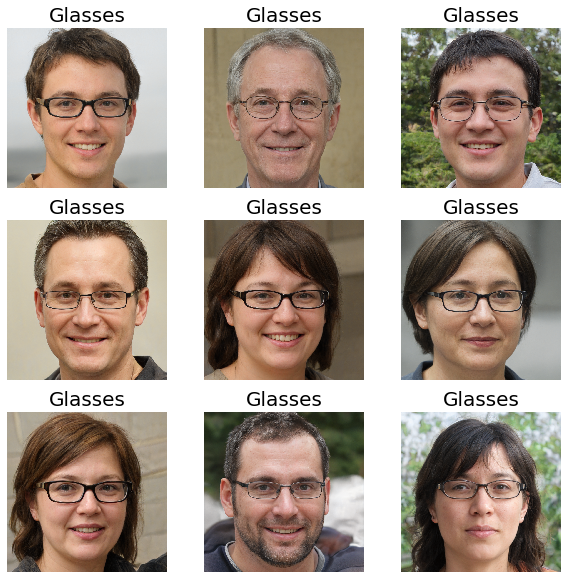

In [154]:

with open("../input/datacleaningglassesnoglasses/glasses.txt", "rb") as fp:
    glass = pickle.load(fp)

# taking 16 random numbers
random_number = []
for _ in range(0,16):
    n = random.randint(0,len(glass))
    random_number.append(n)
    
# plotting some random images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(glass[random_number[i]]))
    plt.title("Glasses", fontsize=20)
    plt.axis("off")

### Reading no_glasses data

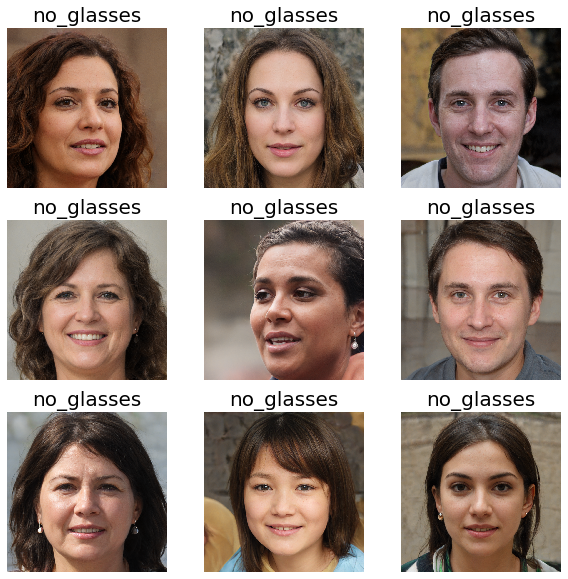

In [155]:

with open("../input/datacleaningglassesnoglasses/no_glasses.txt", "rb") as fp: 
    no_glass = pickle.load(fp)

# taking 16 random numbers
random_number = []
for _ in range(0,16):
    n = random.randint(0,len(no_glass))
    random_number.append(n)

# plotting some random images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_glass[random_number[i]]))
    plt.title("no_glasses", fontsize=20)
    plt.axis("off")

### Reading no_clear data

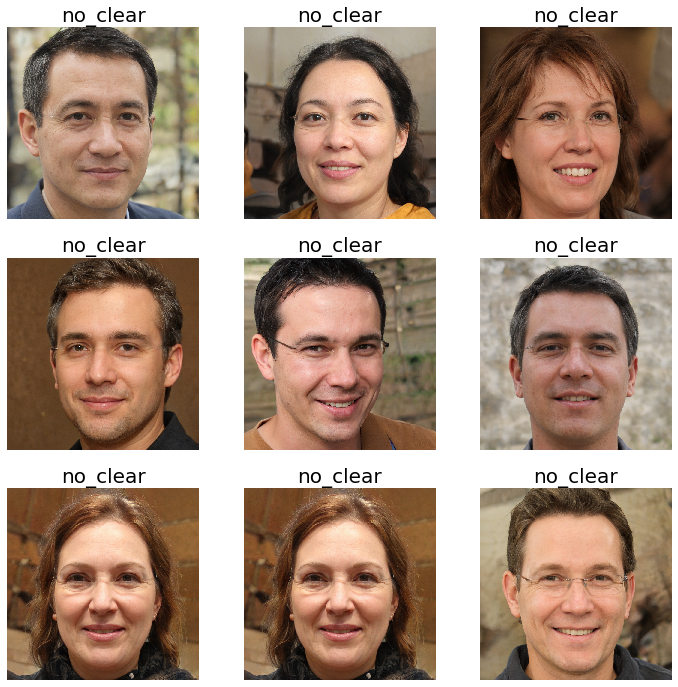

In [156]:

with open("../input/datacleaningglassesnoglasses/no_clear.txt", "rb") as fp: 
    no_clear = pickle.load(fp)

''' taking 16 random numbers '''

random_number = []
for _ in range(0,9):
    n = random.randint(0,len(no_clear))
    random_number.append(n)

''' plotting some random images'''
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(no_clear[random_number[i]]))
    plt.title("no_clear", fontsize=20)
    plt.axis("off")

#### Checking the size of each groups

In [157]:
print("The length of the different groups:" + "-Glasses: " + str(len(glass)) + " -No glasses: " + str(len(no_glass)) + " -No clear: " + str(len(no_clear)))

The length of the different groups:-Glasses: 2770 -No glasses: 2152 -No clear: 77


In [158]:
# setting radom seed
tf.random.set_seed(123456)

#### Initializing batch size and image size

In [159]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

#### Total images

In [160]:
total_images= glass + no_glass

In [161]:
# data directory
dataset_dir= "D:/Data Science/Projects/Imarticus/Capstone_DL/input/datacleaningglassesnoglasses/Images/Images/"

In [162]:
dataset_dir

'D:/Data Science/Projects/Imarticus/Capstone_DL/input/datacleaningglassesnoglasses/Images/Images/'

###  Splitting data into 70-30 split

In [164]:

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 3444 files for training.


In [165]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 4920 files belonging to 2 classes.
Using 1476 files for validation.


#### The train_dataset contains 4920 images, and the validation_datset 1476, out of 4920 files

In [166]:
class_names = train_dataset.class_names
print(class_names)

['glasses', 'no_glasses']


### Plotting images from training data

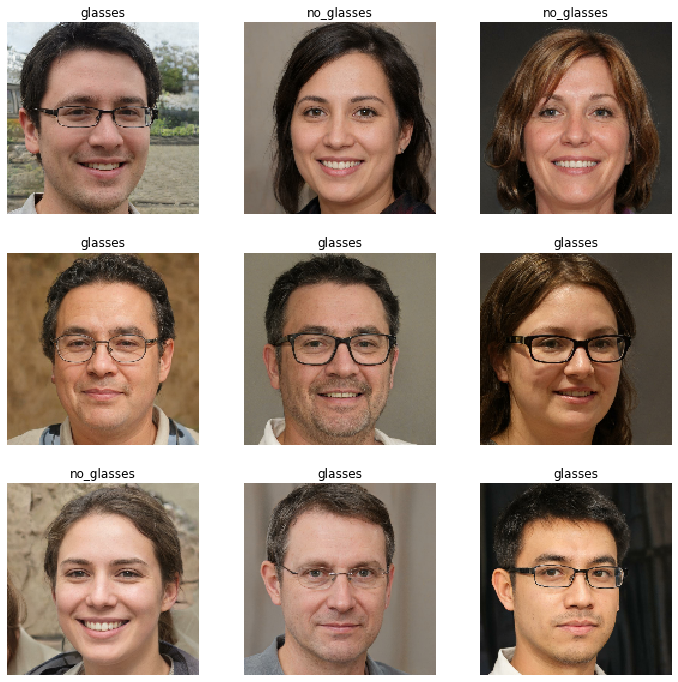

In [167]:

''' taking class names'''
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [168]:
# splitting data from validation data into val and test

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [169]:
# Number of batches in each data

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 108
Number of validation batches: 38
Number of test batches: 9


In [170]:
# This configuration allows the model to speed up the training process

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [171]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

#### images afer doing data augmentation

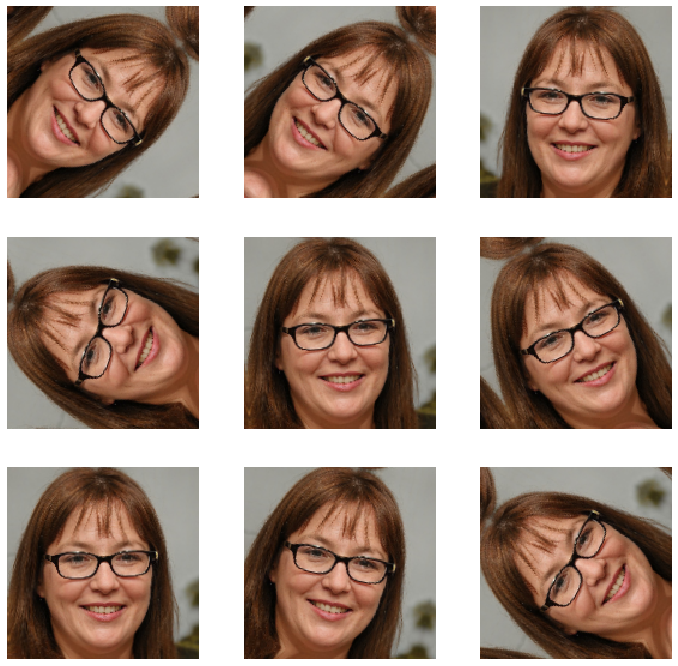

In [172]:

# plotting some images

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Mobilenet preprocess input for Transfer Learning

In [173]:

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [174]:
# scaling images, scaling brings the values of each pixle in range between -1 to 1

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [175]:
# reshaping

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [176]:
# This feature extractor converts the images from 160x160x3 to 5x5x1280 

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [177]:
# freeze top layers

base_model.trainable = False

In [178]:
# adding GlobalAveragePooling2D layers

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [179]:
# Adding Dense Layer, that helps in classification

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [180]:
# aggregating all the things

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [181]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [182]:
# setting up optimizer and loss

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [183]:
len(model.trainable_variables)

2

### Model Evaluation

In [184]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

38/38 [==============================] - 22s 478ms/step - loss: 0.6121 - accuracy: 0.6271


In [185]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.63


### Training

In [186]:

model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
108/108 [==============================] - 88s 757ms/step - loss: 0.6865 - accuracy: 0.6037 - val_loss: 0.5324 - val_accuracy: 0.6524
Epoch 2/10
108/108 [==============================] - 83s 764ms/step - loss: 0.5354 - accuracy: 0.7134 - val_loss: 0.4690 - val_accuracy: 0.7256
Epoch 3/10
108/108 [==============================] - 83s 763ms/step - loss: 0.4470 - accuracy: 0.7724 - val_loss: 0.4210 - val_accuracy: 0.7828
Epoch 4/10
108/108 [==============================] - 83s 765ms/step - loss: 0.3881 - accuracy: 0.8153 - val_loss: 0.3805 - val_accuracy: 0.8173
Epoch 5/10
108/108 [==============================] - 82s 759ms/step - loss: 0.3463 - accuracy: 0.8415 - val_loss: 0.3561 - val_accuracy: 0.8308
Epoch 6/10
108/108 [==============================] - 83s 765ms/step - loss: 0.3077 - accuracy: 0.8641 - val_loss: 0.3281 - val_accuracy: 0.8476
Epoch 7/10
108/108 [==============================] - 83s 760ms/step - loss: 0.2818 - accuracy: 0.8926 - val_loss: 0.3125 - val_ac

In [187]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

In [117]:
## 3.8) Results

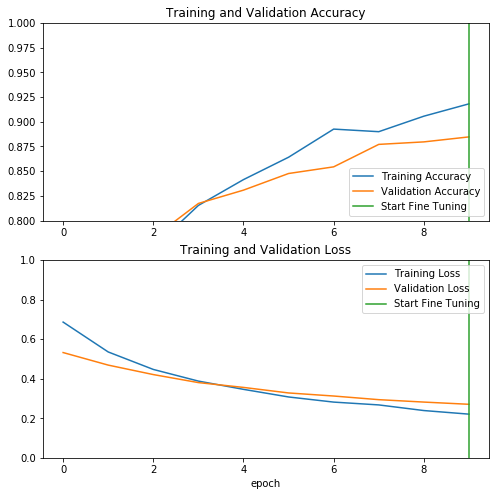

In [188]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [189]:
# evaluation

loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

108/108 [==============================] - 56s 509ms/step - loss: 0.2552 - accuracy: 0.8798
Test accuracy : 0.8993055820465088
Train accuracy : 0.8797909617424011


In [190]:
# unfreeze the top layers

base_model.trainable = True

### Tunning of model

In [191]:

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [192]:
# Compile

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [193]:
len(model.trainable_variables)

56

In [194]:
# Again training the model after fine tuning

fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
108/108 [==============================] - 118s 1s/step - loss: 0.0704 - accuracy: 0.9742 - val_loss: 0.0344 - val_accuracy: 0.9891
Epoch 11/15
108/108 [==============================] - 107s 982ms/step - loss: 0.0276 - accuracy: 0.9907 - val_loss: 0.0264 - val_accuracy: 0.9941
Epoch 12/15
108/108 [==============================] - 107s 986ms/step - loss: 0.0162 - accuracy: 0.9939 - val_loss: 0.0185 - val_accuracy: 0.9949
Epoch 13/15
108/108 [==============================] - 108s 998ms/step - loss: 0.0129 - accuracy: 0.9954 - val_loss: 0.0296 - val_accuracy: 0.9941
Epoch 14/15
108/108 [==============================] - 109s 1s/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.0151 - val_accuracy: 0.9958
Epoch 15/15
108/108 [==============================] - 109s 1s/step - loss: 0.0150 - accuracy: 0.9959 - val_loss: 0.0078 - val_accuracy: 0.9966


In [195]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']


## 4.4) Results

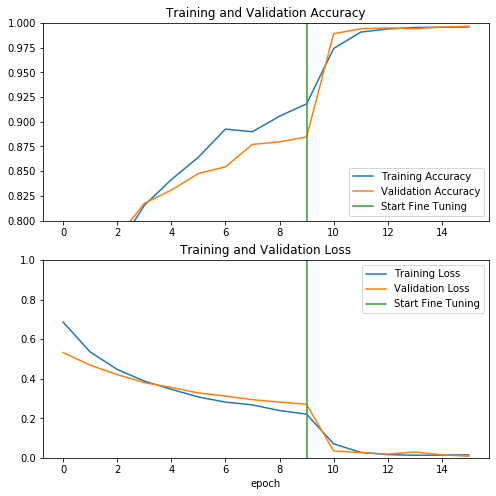

In [196]:
''' Training and Validation accuracy graph'''

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


''' Training and Validation loss graph'''

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [197]:
# evalutaion

loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

38/38 [==============================] - 21s 505ms/step - loss: 0.0138 - accuracy: 0.9958
Test accuracy : 1.0
Train accuracy : 0.9994192719459534
Validation accuracy : 0.9957912564277649


### Prediction

Predictions:
 [1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0]
Labels:
 [1 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0]


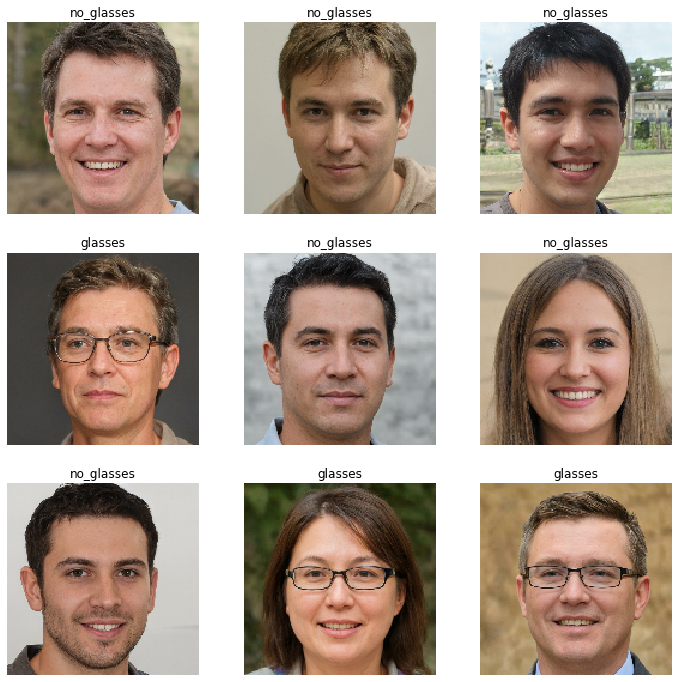

In [200]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")